# Variance and Bias 

In [36]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [38]:
X, y, Xval, yval, Xtest, ytest = load_data()

/home/kuanru/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


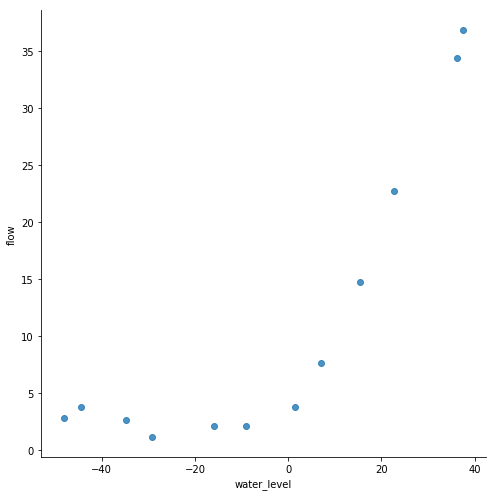

In [39]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [40]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

The data shows the non-linea behavior.

# Cost function

In [41]:
def cost(theta, X, y):
    """
    X: m by n matrix, m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [42]:
theta = np.ones(X.shape[1]) #initial value for theta
cost(theta, X, y) # calculate cost function

303.9515255535976

# Gradient

In [43]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [44]:
gradient(theta, X, y) #check the output for a given theta, x and y

array([-15.30301567, 598.16741084])

# Regularize Gradient

In [45]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [46]:
regularized_gradient(theta, X, y) #check the output for a given theta, x and y

array([-15.30301567, 598.25074417])

# Curve fitting
 For regularized term is equal to $\lambda=0$

In [47]:
def linear_regression_np(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [48]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [49]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x') 

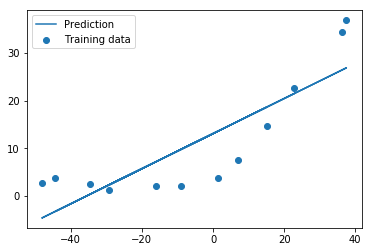

In [50]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

The linear regression model is not fitted vwry well. Below we will change the training set size to observe the learning curves behavior. We compare the result of the training and cross validation set error and give a summary.

In [52]:
training_cost, cv_cost = [], []

In [53]:
m = X.shape[0]
for i in range(1, m+1):
#     print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
#     print('tc={}, cv={}'.format(tc, cv))
    
    training_cost.append(tc)
    cv_cost.append(cv)

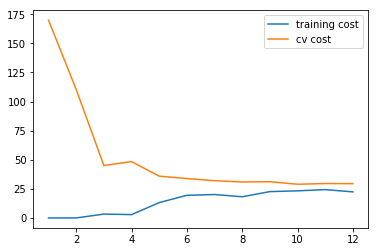

In [54]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

1. We observe that  both the train error and cross validation error are high  when the number of training data is increased. This means that the model reflects a high bias problem.
2. The linear model is too simple to fit our dataset well.

# Polynomial regression